# PCoAの実装

```
class sklearn.decomposition.KernelPCA
(n_components=None, *, kernel='linear',
 gamma=None, degree=3, coef0=1, kernel_params=None, alpha=1.0,
 fit_inverse_transform=False, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None)
```

```
class sklearn.manifold.MDS(n_components=2, *, metric=True, n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None, random_state=None, dissimilarity='euclidean')
```

In [1]:
from sklearn.decomposition import KernelPCA
import numpy as np
import itertools
import sklearn
from sklearn.metrics import pairwise_distances
import warnings

class TrainedData:
    def __init__(self, X=None):
        self.data_ = None
        self.columns_ = None
        self.index_ = None
        if X is not None:
            self.register(X)
    
    def register(self, X):
        if isinstance(X, pd.DataFrame):
            if self.columns_ is not None and list(self.columns_) != list(X.columns):
                warnings.warn('Registered the data with different columns. Columns has renewed.', warnings.UserWarning)
            self.columns_ = X.columns
            X = X.to_numpy()
        if self.data_ is None:
            self.data_ = X
        else:
            self.data_ = np.vstack([self.data_, X])
        return self.data_
    
    @property
    def n_samples_(self):
        return self.data_.shape[0]
    
    @property
    def n_features_(self):
        return self.data_.shape[1]
    
    @property
    def data(self):
        return self.data_
    
    def __call__(self):
        return self.data
    
    def to_pandas(self):
        return pd.DataFrame(self.data, columns=self.columns_)
        

class PCoA():
    """
    # Args
    Based on ``sklearn.decomposition.KernelPCA`` and ``sklearn.manifold.MDS``.
    - n_comopnents
    - dissimilarity
    - dissimilarity_params
    - eigen_solver
    - tol
    - max_iter
    - remove_zero_eig
    - random_state
    - copy_X
    - n_jobs
    
    # How-to-use
    initialize and then just fit_transform. that's all.
    
    # Returns
    Based on ``sklearn.decomposition.KernelPCA`` and ``sklearn.manifold.MDS``.
    - n_samples_
    - n_features_
    - explained_variance_
    - explained_variance_ratio_
    - X_fit_
    - lambdas_
    - alphas_
    
    """
    def __init__(self, n_components=None, *, dissimilarity='euclidean', dissimilarity_params=None, 
                 eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, random_state=None, copy_X=True, n_jobs=None):
        self.n_components_ = n_components
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.kernelpca_ = KernelPCA(n_components, eigen_solver=eigen_solver, tol=tol, max_iter=max_iter, kernel='precomputed',
                                    remove_zero_eig=remove_zero_eig, random_state=random_state, copy_X=copy_X, n_jobs=n_jobs)

        self.dissimilarity = dissimilarity
        self.dissimilarity_params = dissimilarity_params
        self.set_metric(dissimilarity, dissimilarity_params)
        
        self.trained_data = TrainedData()
    
    @staticmethod
    def metric_matrix(X, distance_function):
        d = distance_function
        return d(X, X)
    
    @staticmethod
    def pairwise_metric_from(one_on_one_distance):
        def result_func(X, Y, **args):
            assert(X.shape == Y.shape)
            D = np.zeros((X.shape[0], Y.shape[0]))
            for i in range(X.shape[0]):
                for j in range(Y.shape[0]):
                    D[i, j] = one_on_one_distance(X[i], Y[j])
            return D
        
        return result_func


    def set_metric(self, dissimilarity, dissimilarity_params):
        if isinstance(dissimilarity, str):
            self.metric_ = (lambda X, Y: sklearn.metrics.pairwise_distances(X, Y, metric=dissimilarity))
        else:
            if dissimilarity_params is not None:
                self.metric_ = (lambda X, Y: dissimilarity(X, Y, **dissimilarity_params))
            else:
                self.metric_ = (lambda X, Y: dissimilarity(X, Y))
        return self.metric_

    def fit_transform(self, X, y=None, **params):
        self.trained_data.register(X)
        D = PCoA.metric_matrix(self.X_fit_, self.metric_)
        H = PCoA.centerized(self.n_samples_)
        assert(D.shape == H.shape)
        K_tilde = -1/2 * (H @ (D**2) @ H)
        self.eigenvalues_ = np.sort(np.linalg.eigh(K_tilde)[0])[::-1]
        self.eigenvalues_[np.isclose(self.eigenvalues_, 0)] = 0
        assert(K_tilde.shape == D.shape)
        return self.kernelpca_.fit_transform(K_tilde)
        
    @property
    def n_samples_(self):
        return self.trained_data.n_samples_
    
    @property
    def n_features_(self):
        return self.trained_data.n_features_

    @property
    def explained_variance_ratio_(self, acc=False):
        variances = self.explained_variance_
        tot = np.sum(variances)
        ratios = variances / tot
        if acc:
            return np.array(list(itertools.accumulate(ratios)))
        else:
            return ratios
    
    @property
    def explained_variance_(self):
        return self.lambdas_
    
    @property
    def X_fit_(self):
        return self.trained_data()
    
    @property
    def lambdas_(self):
        return self.kernelpca_.lambdas_
    
    @property
    def alphas_(self):
        return self.kernelpca_.alphas_
    
    @staticmethod
    def centerized(n_dim):
        return np.identity(n_dim) - 1/n_dim * np.ones((n_dim, n_dim))
    

## Usecase 1: Iris data by euclidean

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

In [5]:
df['target'] = iris.target

In [6]:
df['hue'] = iris.target_names[df['target']]

In [7]:
df.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,hue
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa


In [8]:
X = df.iloc[:, :3]
X.head(3)

,sepal length (cm),sepal width (cm),petal length (cm)
0,5.1,3.5,1.4
1,4.9,3.0,1.4
2,4.7,3.2,1.3


In [9]:
model = PCoA(n_components=3, dissimilarity='euclidean', random_state=42, 
             n_jobs=None, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, copy_X=True)
features = model.fit_transform(X)

print(model.explained_variance_, 
      model.explained_variance_ratio_, 
      model.n_components_, 
      model.n_features_, 
      model.n_samples_)


[549.97684855  35.96521365   8.85860447] [0.92464061 0.06046599 0.0148934 ] 3 3 150


<AxesSubplot:xlabel='p0', ylabel='p1'>

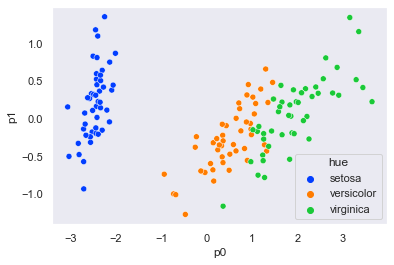

In [10]:
import seaborn as sns
plotted = pd.DataFrame(features, columns=['p'+str(i) for i in range(model.n_features_)])
plotted['hue'] = df['hue']
sns.set(style='dark', palette='bright')
sns.scatterplot(data=plotted, x='p0', y='p1', hue='hue')

In [11]:
pos_var = model.eigenvalues_[model.eigenvalues_ > 0]
neg_var = model.eigenvalues_[model.eigenvalues_ < 0]

In [12]:
p = pos_var / np.sum(pos_var)
p

array([0.92464061, 0.06046599, 0.0148934 ])

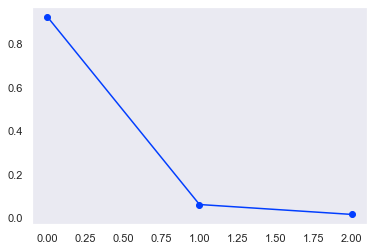

In [13]:
plt.plot(p, marker='o')

In [14]:
n = neg_var / np.sum(neg_var)
n

array([], dtype=float64)

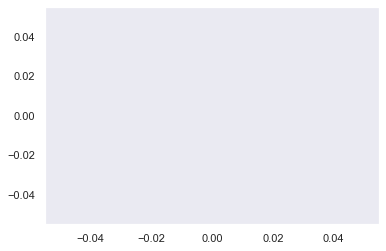

In [15]:
plt.plot(n, marker='o')

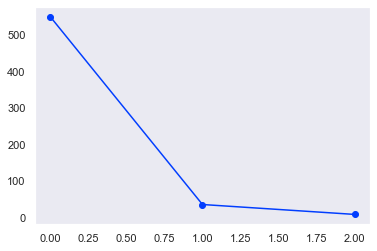

In [16]:
plt.plot(model.eigenvalues_[model.eigenvalues_ !=0], marker='o')

# Usecase 1-2: Iris data by manhattan. 

In [17]:
model = PCoA(n_components=3, dissimilarity='manhattan', random_state=42, 
             n_jobs=None, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, copy_X=True)
features = model.fit_transform(X)

print(model.explained_variance_, 
      model.explained_variance_ratio_, 
      model.n_components_, 
      model.n_features_, 
      model.n_samples_)


[1085.50977993  131.78625779   38.60953353] [0.86432436 0.10493325 0.03074239] 3 3 150


<AxesSubplot:xlabel='p0', ylabel='p1'>

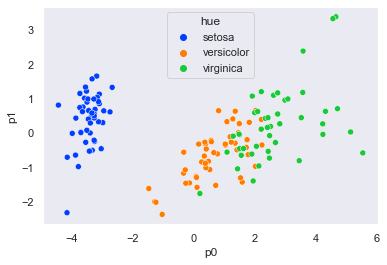

In [18]:
import seaborn as sns
plotted = pd.DataFrame(features, columns=['p'+str(i) for i in range(model.n_features_)])
plotted['hue'] = df['hue']
sns.set(style='dark', palette='bright')
sns.scatterplot(data=plotted, x='p0', y='p1', hue='hue')

In [19]:
pos_var = model.eigenvalues_[model.eigenvalues_ > 0]
neg_var = model.eigenvalues_[model.eigenvalues_ < 0]

In [20]:
p = pos_var / np.sum(pos_var)
p

array([7.91678280e-01, 9.61136600e-02, 2.81585018e-02, 1.51613941e-02,
       1.17543143e-02, 1.00976439e-02, 6.30752073e-03, 5.12222718e-03,
       4.73344419e-03, 3.90634929e-03, 3.67139089e-03, 2.66823292e-03,
       2.28750853e-03, 1.97188803e-03, 1.81787866e-03, 1.57729470e-03,
       1.34997120e-03, 1.33583767e-03, 1.14395404e-03, 9.85534009e-04,
       8.79066218e-04, 8.54894937e-04, 8.24631087e-04, 7.78041679e-04,
       6.03759107e-04, 4.54374183e-04, 4.27235220e-04, 3.99585135e-04,
       3.61929931e-04, 3.23125813e-04, 2.68502874e-04, 2.44670119e-04,
       2.38182486e-04, 2.27451150e-04, 1.89518021e-04, 1.44765611e-04,
       1.40288685e-04, 1.29646881e-04, 1.15552325e-04, 1.11456311e-04,
       9.03537758e-05, 7.03454572e-05, 6.26685178e-05, 5.87868898e-05,
       4.72080946e-05, 3.31692606e-05, 2.21704513e-05, 1.73637430e-05,
       1.64380100e-05, 1.10561904e-05, 7.27133719e-06, 3.66391526e-06])

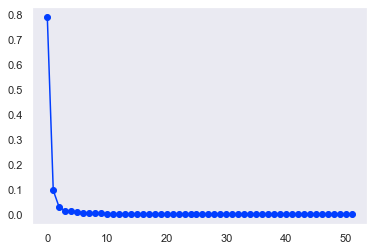

In [21]:
plt.plot(p, marker='o')

In [22]:
n = neg_var / np.sum(neg_var)
n

array([1.39235019e-05, 5.84777003e-05, 7.16779549e-05, 8.95798079e-05,
       1.07445625e-04, 1.25498520e-04, 1.49789753e-04, 1.69726974e-04,
       1.84049102e-04, 2.44450939e-04, 2.77098840e-04, 2.99414107e-04,
       3.17081376e-04, 3.32712768e-04, 3.55482818e-04, 3.71251568e-04,
       4.35819585e-04, 4.46211555e-04, 4.94162570e-04, 5.34844108e-04,
       5.58556781e-04, 5.89016936e-04, 6.11348254e-04, 6.44544108e-04,
       6.64869331e-04, 6.67886471e-04, 6.94366862e-04, 7.67548636e-04,
       7.92340387e-04, 8.42738808e-04, 8.97873272e-04, 9.38458800e-04,
       1.02003390e-03, 1.03366430e-03, 1.06569437e-03, 1.11566479e-03,
       1.14682163e-03, 1.17783132e-03, 1.26629909e-03, 1.38021871e-03,
       1.40483733e-03, 1.47271521e-03, 1.48488064e-03, 1.57699527e-03,
       1.66496778e-03, 1.79385466e-03, 1.80361158e-03, 1.86644290e-03,
       1.91469816e-03, 2.04061105e-03, 2.14307995e-03, 2.37552504e-03,
       2.52329674e-03, 2.64472113e-03, 2.77400850e-03, 2.83384085e-03,
      

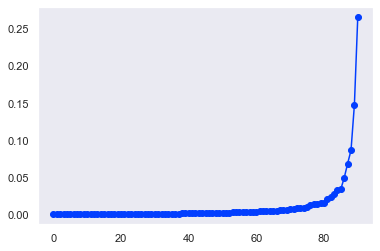

In [23]:
plt.plot(n, marker='o')

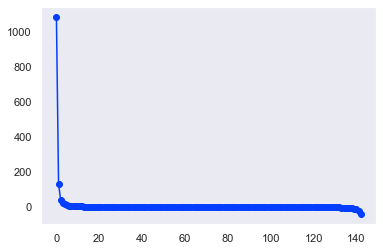

In [24]:
plt.plot(model.eigenvalues_[model.eigenvalues_ !=0], marker='o')

## Usecase 2: 2D-Circle by radial distance.

In [25]:
T = np.linspace(0, np.pi, 21)
X = np.array([np.cos(T), np.sin(T)])

In [26]:
X = X.T

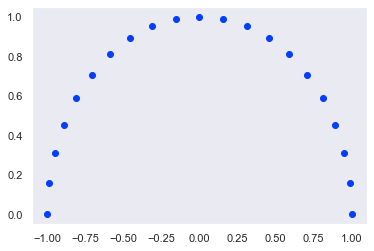

In [27]:
plt.scatter(*X.T)

In [28]:
def distance(x, y):
    def theta(x):    
        (x_cos, x_sin) = (np.arccos(x[0]), np.arcsin(x[1]))
        if x_sin >= 0:
            t = x_cos
        else:
            t = 2*np.pi - x_cos
        return t
    
    theta1 = theta(x)
    theta2 = theta(y)
    result = max([theta1, theta2]) - min([theta1, theta2])
    if result > np.pi:
        result = np.pi * 2 - result
    return result

In [29]:
dissimilarity = PCoA.pairwise_metric_from(distance)

In [30]:
dissimilarity(X, X) * 180 / np.pi

array([[  0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,  90.,
         99., 108., 117., 126., 135., 144., 153., 162., 171., 180.],
       [  9.,   0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,  81.,
         90.,  99., 108., 117., 126., 135., 144., 153., 162., 171.],
       [ 18.,   9.,   0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,  72.,
         81.,  90.,  99., 108., 117., 126., 135., 144., 153., 162.],
       [ 27.,  18.,   9.,   0.,   9.,  18.,  27.,  36.,  45.,  54.,  63.,
         72.,  81.,  90.,  99., 108., 117., 126., 135., 144., 153.],
       [ 36.,  27.,  18.,   9.,   0.,   9.,  18.,  27.,  36.,  45.,  54.,
         63.,  72.,  81.,  90.,  99., 108., 117., 126., 135., 144.],
       [ 45.,  36.,  27.,  18.,   9.,   0.,   9.,  18.,  27.,  36.,  45.,
         54.,  63.,  72.,  81.,  90.,  99., 108., 117., 126., 135.],
       [ 54.,  45.,  36.,  27.,  18.,   9.,   0.,   9.,  18.,  27.,  36.,
         45.,  54.,  63.,  72.,  81.,  90.,  99., 108., 117., 126.],

In [31]:
model = PCoA(n_components=2, dissimilarity=dissimilarity, random_state=42, 
             n_jobs=None, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, copy_X=True)
features = model.fit_transform(X)

print(model.explained_variance_, 
      model.explained_variance_ratio_, 
      model.n_components_, 
      model.n_features_, 
      model.n_samples_)


[18.99898847  0.        ] [1. 0.] 2 2 21


<AxesSubplot:xlabel='p0', ylabel='p1'>

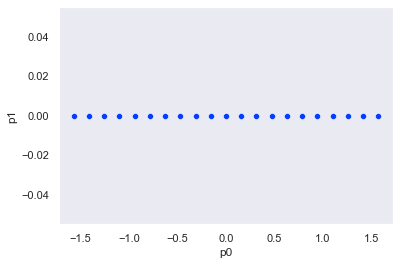

In [32]:
import seaborn as sns
plotted = pd.DataFrame(features, columns=['p'+str(i) for i in range(model.n_features_)])
# plotted['hue'] = df['hue']
sns.set(style='dark', palette='bright')
sns.scatterplot(data=plotted, x='p0', y='p1')

In [33]:
pos_var = model.eigenvalues_[model.eigenvalues_ > 0]
neg_var = model.eigenvalues_[model.eigenvalues_ < 0]

In [34]:
pos_var

array([18.99898847])

In [35]:
neg_var = neg_var[::-1]
neg_var

array([], dtype=float64)

In [36]:
p = pos_var / np.sum(pos_var)
p

array([1.])

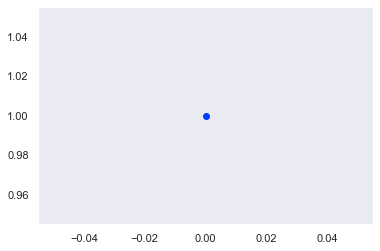

In [37]:
plt.plot(p, marker='o')

In [38]:
n = neg_var / np.sum(neg_var)
n

array([], dtype=float64)

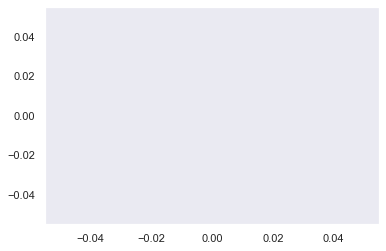

In [39]:
plt.plot(n, marker='o')

In [40]:
len(model.eigenvalues_[model.eigenvalues_ == 0])

20

# Usecase 2-2:

In [41]:
T = np.linspace(0, 2 * np.pi, 21)
X = np.array([np.cos(T), np.sin(T)])

In [42]:
X = X.T

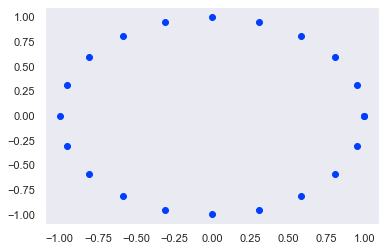

In [43]:
plt.scatter(*X.T)

In [44]:
def distance(x, y):
    def theta(x):    
        (x_cos, x_sin) = (np.arccos(x[0]), np.arcsin(x[1]))
        if x_sin >= 0:
            t = x_cos
        else:
            t = 2*np.pi - x_cos
        return t
    
    theta1 = theta(x)
    theta2 = theta(y)
    result = max([theta1, theta2]) - min([theta1, theta2])
    if result > np.pi:
        result = np.pi * 2 - result
    return result

In [45]:
dissimilarity = PCoA.pairwise_metric_from(distance)

In [46]:
dissimilarity(X, X) * 180 / np.pi

array([[  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.,
        162., 144., 126., 108.,  90.,  72.,  54.,  36.,  18.,   0.],
       [ 18.,   0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162.,
        180., 162., 144., 126., 108.,  90.,  72.,  54.,  36.,  18.],
       [ 36.,  18.,   0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144.,
        162., 180., 162., 144., 126., 108.,  90.,  72.,  54.,  36.],
       [ 54.,  36.,  18.,   0.,  18.,  36.,  54.,  72.,  90., 108., 126.,
        144., 162., 180., 162., 144., 126., 108.,  90.,  72.,  54.],
       [ 72.,  54.,  36.,  18.,   0.,  18.,  36.,  54.,  72.,  90., 108.,
        126., 144., 162., 180., 162., 144., 126., 108.,  90.,  72.],
       [ 90.,  72.,  54.,  36.,  18.,   0.,  18.,  36.,  54.,  72.,  90.,
        108., 126., 144., 162., 180., 162., 144., 126., 108.,  90.],
       [108.,  90.,  72.,  54.,  36.,  18.,   0.,  18.,  36.,  54.,  72.,
         90., 108., 126., 144., 162., 180., 162., 144., 126., 108.],

In [47]:
model = PCoA(n_components=2, dissimilarity=dissimilarity, random_state=42, 
             n_jobs=None, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False, copy_X=True)
features = model.fit_transform(X)

print(model.explained_variance_, 
      model.explained_variance_ratio_, 
      model.n_components_, 
      model.n_features_, 
      model.n_samples_)


[22.06811408 20.16530834] [0.52252725 0.47747275] 2 2 21


<AxesSubplot:xlabel='p0', ylabel='p1'>

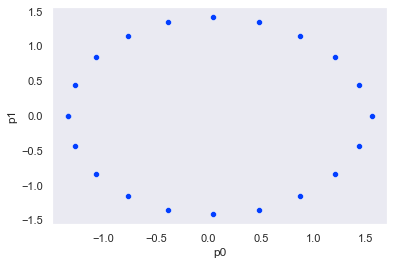

In [48]:
import seaborn as sns
plotted = pd.DataFrame(features, columns=['p'+str(i) for i in range(model.n_features_)])
# plotted['hue'] = df['hue']
sns.set(style='dark', palette='bright')
sns.scatterplot(data=plotted, x='p0', y='p1')

In [49]:
pos_var = model.eigenvalues_[model.eigenvalues_ > 0]
neg_var = model.eigenvalues_[model.eigenvalues_ < 0]

In [50]:
pos_var

array([22.06811408, 20.16530834,  2.59421154,  2.39428707,  1.06093286,
        0.98696044,  0.66176566,  0.62159567,  0.52653307,  0.50585948])

In [51]:
neg_var = neg_var[::-1]
neg_var

array([-5.62669608, -5.16779196, -1.54128907, -1.42834257, -0.80710002,
       -0.75397069, -0.57598435, -0.54557831, -0.50120354])

In [52]:
p = pos_var / np.sum(pos_var)
p

array([0.42779628, 0.39090988, 0.05028948, 0.04641389, 0.02056647,
       0.01913249, 0.0128285 , 0.0120498 , 0.01020698, 0.00980622])

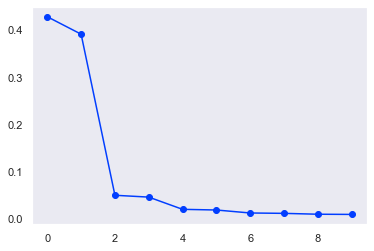

In [53]:
plt.plot(p, marker='o')

In [54]:
n = neg_var / np.sum(neg_var)
n

array([0.3319985 , 0.30492124, 0.09094247, 0.08427816, 0.04762226,
       0.04448741, 0.03398547, 0.03219139, 0.0295731 ])

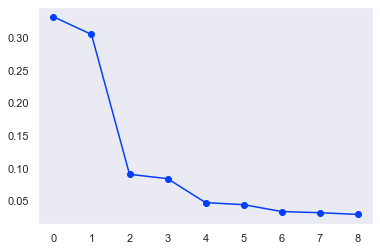

In [55]:
plt.plot(n, marker='o')

In [56]:
len(model.eigenvalues_[model.eigenvalues_ == 0])

2